# Framing Analysis for Debates and Media Outlets

This notebook documents the **Framing Analysis pipeline** for the BSc thesis:  
`Debates, Media, and Discourse: A Computational Analysis of Temporal Shifts in U.S. Presidential Debates and Media Framing Across the Political Spectrum`, written by **Emma Cristina Mora** (emma.mora@studbocconi.it) at **Bocconi University** under the supervision of **Professor Carlo Rasmus Schwarz**.

The purpose of this stage is to classify **frames** in U.S. presidential debates (1960–2024) and in **media coverage** (Factiva articles from *New York Times*, *Wall Street Journal*, and *New York Post*, 2012–2024). This allows for systematic comparisons of how issues are framed across political actors and media outlets, and how these patterns evolve over time.

**Frame Taxonomy**
- Following Entman (1993) and Gamson & Modigliani (1989), a set of **five master frames** was defined:  
  *economic consequences, legality and constitutionality, security and safety, morality and ethics, fairness and social justice*.  
- Each frame was paired with a consistent **hypothesis template**:  
  *“This text frames the issue in terms of {}.”*  
- A domain-tuned set of **verbalizers** (synonyms and political keywords, e.g. “jobs,” “Supreme Court,” “border security”) was also developed to improve robustness, though the final runs used the canonical 5-label version for efficiency.

**Debates Dataset**
- Source: `debates_df_themes.csv`, containing ~9,300 utterances (cleaned, normalized, annotated with speakers, parties, themes).  
- Frame classification applied to all utterances (1960–2024).  
- Confidence analysis showed debates are **noisier**: mean best-score ~0.45, many utterances with small margins between top-two frames.  
- After applying a conservative threshold (`score ≥ 0.45`, `margin ≥ 0.1`), ~59% of debate utterances were marked as `"unspecified"`.  
- Frames that survived filtering were dominated by *economic* and *security* framings.

**Media Dataset**
- Source: `media_chunks_pred_balanced.csv`, containing 675 balanced chunks (225 per outlet).  
- Classification applied at the chunk level.  
- Media predictions were **clearer and more confident**: mean best-score ~0.53, higher margins.  
- After filtering, ~36% of chunks became `"unspecified"`, with surviving frames dominated by *economic* (~51%) and *security* (~10%).  

**Quality Control**
- Section 5 explored **score distributions** and **confidence margins** for both debates and media.  
- Filtering rules (`p ≥ 0.45`, `margin ≥ 0.1`) were applied to reduce low-confidence assignments.  
- Diagnostics confirmed the classifier is more decisive on media than on debate utterances, highlighting structural differences in discourse style.

**Aggregation Attempt**
- Debate utterances were aggregated by `debate_id × speaker × theme_name` to provide more context.  
- Reclassification of these aggregated texts did **not substantially improve scores**, confirming that framing signals are inherently weaker in fragmented debate speech.

**Notebook Summary**
- Section 1: Setup and configuration (libraries, file paths, constants).  
- Section 2: Load debates and media datasets.  
- Section 3: Define taxonomy, verbalizers, and load zero-shot model.  
- Section 4: Apply classifier to debates (full run) and media (balanced chunks).  
- Section 5: Quality control — score distributions, margins, filtering with thresholds, and distribution comparisons.  
- Section 6: Aggregation of debate utterances (diagnostics showed limited improvements).  
- Final outputs:  
  - `debates_frames_simple.csv`  
  - `media_frames_simple.csv`  

## 1. Introduction and Config

In [2]:
# === LIBRARIES ===

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import tqdm

In [3]:
# === PATHS & CONSTANTS ===

from google.colab import drive
drive.mount('/content/drive')

REPO_DIR   = REPO_DIR = Path("/content/drive/MyDrive/thesis/data/")

DEBATES_FILE = REPO_DIR / "debates" / "topic modeling" / "debates_df_themes.csv"
MEDIA_FILE  = REPO_DIR / "debates-media alignment" / "media_chunks_pred_balanced.csv"

# confirm setup
print("Repository Path:", REPO_DIR)
print("Debates Dataset:", DEBATES_FILE)
print("Media Dataset:", MEDIA_FILE)

# reproducibility
RANDOM_SEED = 42

Mounted at /content/drive
Repository Path: /content/drive/MyDrive/thesis/data
Debates Dataset: /content/drive/MyDrive/thesis/data/debates/topic modeling/debates_df_themes.csv
Media Dataset: /content/drive/MyDrive/thesis/data/debates-media alignment/media_chunks_pred_balanced.csv


## 2. Load Data

In [4]:
# === DEBATES DATASET (whole data) ===

# load debates dataset and inspect schema
df_debates = pd.read_csv(DEBATES_FILE)

print(f"[INFO] Debates dataset (full) loaded: {len(df_debates):,} rows")
print(df_debates.head(3))
print("\n[INFO] Columns:", list(df_debates.columns))

[INFO] Debates dataset (full) loaded: 6,316 rows
                                                text speaker_normalized  \
0  good evening. the television and radio station...          Moderator   
1  mr. smith, mr. nixon. in the election of 1860,...        Candidate_D   
2  mr. smith, senator kennedy. the things that se...        Candidate_R   

     speaker       party   winner winner_party  year   debate_type  \
0  Moderator         NaN  Kennedy     Democrat  1960  presidential   
1    Kennedy    Democrat  Kennedy     Democrat  1960  presidential   
2      Nixon  Republican  Kennedy     Democrat  1960  presidential   

                           debate_id                           utterance_id  \
0  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_001   
1  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_002   
2  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_004   

                                     lemmatized_text

In [5]:
# === MEDIA DATASET (balanced per outlet) ===

# load media dataset and inspect schema
df_media = pd.read_csv(MEDIA_FILE)

print(f"[INFO] Media dataset (balanced) loaded: {len(df_media):,} rows")
print(df_media.head(3))
print("\n[INFO] Columns:", list(df_media.columns))

[INFO] Media dataset (balanced) loaded: 675 rows
   __media_id  year outlet                      source_theme  chunk_index  \
0         440  2016    nyp          healthcare_public_health            2   
1         444  2016    nyp          healthcare_public_health            1   
2         278  2024    nyp  foreign_policy_national_security            7   

                                          chunk_text  \
0  stone said. jonathan gruber, the mit professor...   
1  "we're thinking of having him in the spin room...   
2  iowa caucuses. trump was right when he accused...   

                   pred_theme  pred_sim                second_theme  \
0  healthcare_social_security  0.724106     public_health_pandemics   
1  healthcare_social_security  0.717676     public_health_pandemics   
2     judiciary_supreme_court  0.747351  healthcare_social_security   

   second_sim    margin                                      chunk_preview  \
0    0.448441  0.275665  stone said. jonathan gruber, 

## 3. Frame Taxonomy & Model Setup

In [6]:
# === FRAME TAXONOMY (CANONICAL LABELS + DEFINITIONS) ===
# comments: use short noun-phrase labels; keep a single hypothesis template for consistency

FRAME_LABELS = [
    "economic consequences",
    "legality and constitutionality",
    "security and safety",
    "morality and ethics",
    "fairness and social justice",
]

# definitions for documentation / exports (not fed to the model)
FRAME_DEFINITIONS = {
    "economic consequences": "costs/benefits, jobs, taxes, budgets, growth, trade, material prosperity.",
    "legality and constitutionality": "law, rights, courts, the Constitution, legality/illegality of actions.",
    "security and safety": "national security, defense, crime, policing, terrorism, public health safety.",
    "morality and ethics": "religious/ethical values, right vs wrong, virtue/vice, cultural norms.",
    "fairness and social justice": "equality, discrimination, civil rights, representation, group justice.",
}

# single, consistent hypothesis template (MNLI-style)
HYPOTHESIS_TEMPLATE = "This text frames the issue in terms of {}."

print("[INFO] Frames:", FRAME_LABELS)
print("[INFO] Hypothesis template:", HYPOTHESIS_TEMPLATE)

[INFO] Frames: ['economic consequences', 'legality and constitutionality', 'security and safety', 'morality and ethics', 'fairness and social justice']
[INFO] Hypothesis template: This text frames the issue in terms of {}.


In [7]:
# === DOMAIN-TUNED VERBALIZERS (US POLITICS CONTEXT) ===

# did not use in the end given the large sizes of the datasets 
FRAME_VERBALIZERS = {
    "economic consequences": [
        "economic consequences", "jobs and growth", "inflation", "taxation",
        "deficits and budgets", "trade deals", "manufacturing", "economic prosperity"
    ],
    "legality and constitutionality": [
        "legality and constitutionality", "Supreme Court", "constitutional rights",
        "rule of law", "legal compliance", "due process", "2nd Amendment", "judicial oversight"
    ],
    "security and safety": [
        "security and safety", "national security", "border security",
        "law and order", "crime and policing", "terrorism threats", "military defense", "public health safety"
    ],
    "morality and ethics": [
        "morality and ethics", "religious and moral values", "faith", "family values",
        "moral duty", "virtue and vice", "pro-life and pro-choice", "ethical principles"
    ],
    "fairness and social justice": [
        "fairness and social justice", "civil rights", "racial justice", "gender equality",
        "equity and inclusion", "discrimination", "minority justice", "equal opportunity"
    ],
}

VERBALIZER_CANDIDATES = [v for vs in FRAME_VERBALIZERS.values() for v in vs]
print(f"[INFO] Updated verbalizer candidates: {len(VERBALIZER_CANDIDATES)} strings across {len(FRAME_VERBALIZERS)} frames")

[INFO] Updated verbalizer candidates: 40 strings across 5 frames


In [8]:
# === MODEL SETUP ===
# bart-large-mnli is fast; deberta-v3-large-zeroshot-v2 is stronger but slower

import torch
from transformers import pipeline

MODEL_NAME = "facebook/bart-large-mnli"  # alt: "MoritzLaurer/deberta-v3-large-zeroshot-v2"

classifier = pipeline(
    task="zero-shot-classification",
    model=MODEL_NAME,
    device=0 if torch.cuda.is_available() else -1,
)

print(f"[INFO] Zero-shot classifier loaded: {MODEL_NAME}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


[INFO] Zero-shot classifier loaded: facebook/bart-large-mnli


In [9]:
# === SIMPLE CLASSIFICATION (CANONICAL LABELS) ===
# single pass using canonical labels + one hypothesis template for consistency

from typing import List, Dict
import pandas as pd
from tqdm.auto import tqdm

def zeroshot_classify_simple(
    texts: List[str],
    labels: List[str] = FRAME_LABELS,
    hypothesis_template: str = HYPOTHESIS_TEMPLATE,
    batch_size: int = 32,
) -> pd.DataFrame:
    rows = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Classifying (simple)"):
        batch = texts[i:i+batch_size]
        res = classifier(
            batch,
            candidate_labels=labels,
            hypothesis_template=hypothesis_template,
            multi_label=False,
        )
        if isinstance(res, dict):  # edge case: single text
            res = [res]
        for r in res:
            # sort by score desc
            pairs = list(zip(r["labels"], r["scores"]))
            pairs.sort(key=lambda x: x[1], reverse=True)
            best, best_score = pairs[0]
            second, second_score = pairs[1]
            rows.append({
                "best_frame": best,
                "best_score": float(best_score),
                "second_frame": second,
                "second_score": float(second_score),
            })
    return pd.DataFrame(rows)

In [10]:
# === VERBALIZER-AGGREGATED CLASSIFICATION (ROBUST) ===
# one pass over all verbalizer strings; aggregate per-frame by max or mean

from collections import defaultdict

def _aggregate_scores_by_frame(
    labels: List[str],
    scores: List[float],
    frame_verbalizers: Dict[str, List[str]],
    agg: str = "max",  # or "mean"
) -> Dict[str, float]:
    # map label->score
    score_map = {lab: sc for lab, sc in zip(labels, scores)}
    frame_scores = {}
    for frame, vers in frame_verbalizers.items():
        vals = [score_map.get(v, 0.0) for v in vers]
        if agg == "mean":
            frame_scores[frame] = float(sum(vals) / max(len(vals), 1))
        else:  # max
            frame_scores[frame] = float(max(vals) if vals else 0.0)
    return frame_scores

def zeroshot_classify_verbalizers(
    texts: List[str],
    frame_verbalizers: Dict[str, List[str]] = FRAME_VERBALIZERS,
    hypothesis_template: str = HYPOTHESIS_TEMPLATE,
    batch_size: int = 32,
    agg: str = "max",
) -> pd.DataFrame:
    candidates = [v for vs in frame_verbalizers.values() for v in vs]
    rows = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Classifying (verbalizers)"):
        batch = texts[i:i+batch_size]
        res = classifier(
            batch,
            candidate_labels=candidates,
            hypothesis_template=hypothesis_template,
            multi_label=False,
        )
        if isinstance(res, dict):
            res = [res]
        for r in res:
            frame_scores = _aggregate_scores_by_frame(r["labels"], r["scores"], frame_verbalizers, agg=agg)
            # rank frames
            ranked = sorted(frame_scores.items(), key=lambda x: x[1], reverse=True)
            (best, best_score), (second, second_score) = ranked[0], ranked[1]
            rows.append({
                "best_frame": best,
                "best_score": float(best_score),
                "second_frame": second,
                "second_score": float(second_score),
            })
    return pd.DataFrame(rows)

## 4. Apply to Datasets

In [11]:
# === DRY RUN SAMPLE ===
# comments: test pipeline on a small random sample to check outputs and distribution

# sample a few debate utterances and media chunks
sample_debates = df_debates["text"].dropna().sample(30, random_state=RANDOM_SEED).tolist()
sample_media = df_media["chunk_text"].dropna().sample(15, random_state=RANDOM_SEED).tolist()

# run classification on sample
sample_results = zeroshot_classify_verbalizers(sample_debates[:15])
print("[INFO] Sample debate frames:\n", sample_results["best_frame"].value_counts(), "\n")

media_results = zeroshot_classify_verbalizers(sample_media[:10])
print("[INFO] Sample media frames:\n", media_results["best_frame"].value_counts())

Classifying (verbalizers):   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Sample debate frames:
 best_frame
morality and ethics            7
economic consequences          4
security and safety            2
fairness and social justice    2
Name: count, dtype: int64 



Classifying (verbalizers):   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Sample media frames:
 best_frame
economic consequences    4
morality and ethics      4
security and safety      2
Name: count, dtype: int64


### 4.1. Debates

In [12]:
# === CLASSIFY FULL DEBATES DATASET (SIMPLE 5 LABELS) ===

FRAMES_DIR = REPO_DIR / "frames"
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

debate_texts = df_debates["text"].dropna().tolist()

all_batches = []
BATCH_SIZE = 32
SAVE_CHUNK = 1000  # utterances per partial screening

for i in tqdm(range(0, len(debate_texts), SAVE_CHUNK), desc="Debates (full run - simple)"):
    batch_texts = debate_texts[i:i+SAVE_CHUNK]

    # classify this chunk with simple classifier
    batch_frames = zeroshot_classify_simple(batch_texts, batch_size=BATCH_SIZE)

    # print distribution for this batch
    print(f"\n[INFO] Batch {i//SAVE_CHUNK} ({len(batch_frames)} utterances)")
    print(batch_frames["best_frame"].value_counts())

    all_batches.append(batch_frames)

# merge all chunks
debate_frames_full = pd.concat(all_batches, axis=0).reset_index(drop=True)

# merge with original debates dataframe
df_debates_frames = pd.concat([df_debates.reset_index(drop=True), debate_frames_full], axis=1)

print("\n[INFO] Debate framing classification complete (SIMPLE):", df_debates_frames.shape)
print(df_debates_frames[["text", "best_frame", "best_score"]].head())

Debates (full run - simple):   0%|          | 0/7 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/32 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



[INFO] Batch 0 (1000 utterances)
best_frame
economic consequences             352
security and safety               239
morality and ethics               213
fairness and social justice       170
legality and constitutionality     26
Name: count, dtype: int64


Classifying (simple):   0%|          | 0/32 [00:00<?, ?it/s]


[INFO] Batch 1 (1000 utterances)
best_frame
economic consequences             418
morality and ethics               277
fairness and social justice       173
security and safety               114
legality and constitutionality     18
Name: count, dtype: int64


Classifying (simple):   0%|          | 0/32 [00:00<?, ?it/s]


[INFO] Batch 2 (1000 utterances)
best_frame
economic consequences             318
security and safety               257
morality and ethics               254
fairness and social justice       137
legality and constitutionality     34
Name: count, dtype: int64


Classifying (simple):   0%|          | 0/32 [00:00<?, ?it/s]


[INFO] Batch 3 (1000 utterances)
best_frame
economic consequences             460
morality and ethics               222
security and safety               193
fairness and social justice       102
legality and constitutionality     23
Name: count, dtype: int64


Classifying (simple):   0%|          | 0/32 [00:00<?, ?it/s]


[INFO] Batch 4 (1000 utterances)
best_frame
morality and ethics               373
economic consequences             261
security and safety               232
fairness and social justice       103
legality and constitutionality     31
Name: count, dtype: int64


Classifying (simple):   0%|          | 0/32 [00:00<?, ?it/s]


[INFO] Batch 5 (1000 utterances)
best_frame
morality and ethics               337
economic consequences             297
security and safety               192
fairness and social justice       135
legality and constitutionality     39
Name: count, dtype: int64


Classifying (simple):   0%|          | 0/10 [00:00<?, ?it/s]


[INFO] Batch 6 (316 utterances)
best_frame
economic consequences             114
morality and ethics                73
security and safety                64
fairness and social justice        47
legality and constitutionality     18
Name: count, dtype: int64

[INFO] Debate framing classification complete (SIMPLE): (6316, 24)
                                                text  \
0  good evening. the television and radio station...   
1  mr. smith, mr. nixon. in the election of 1860,...   
2  mr. smith, senator kennedy. the things that se...   
3  thank you, mr. nixon. that completes the openi...   
4  senator, the vice president in his campaign ha...   

                       best_frame  best_score  
0             security and safety    0.234098  
1           economic consequences    0.313798  
2  legality and constitutionality    0.263287  
3     fairness and social justice    0.272390  
4             morality and ethics    0.405186  


### 4.2. Media Outlets

In [13]:
# === CLASSIFY BALANCED MEDIA CHUNCKS DATASET (SIMPLE 5 LABELS) ===

media_texts = df_media["chunk_text"].dropna().tolist()

all_batches = []
BATCH_SIZE = 32
SAVE_CHUNK = 1000  # utterances per partial screening

for i in tqdm(range(0, len(media_texts), SAVE_CHUNK), desc="Media Chunks (full run - simple)"):
    batch_texts = media_texts[i:i+SAVE_CHUNK]

    # classify this chunk with simple classifier
    batch_frames = zeroshot_classify_simple(batch_texts, batch_size=BATCH_SIZE)

    # print distribution for this batch
    print(f"\n[INFO] Batch {i//SAVE_CHUNK} ({len(batch_frames)} utterances)")
    print(batch_frames["best_frame"].value_counts())

    all_batches.append(batch_frames)

# merge all chunks
media_frames_full = pd.concat(all_batches, axis=0).reset_index(drop=True)

# merge with original debates dataframe
df_media_frames = pd.concat([df_media.reset_index(drop=True), media_frames_full], axis=1)

print("\n[INFO] Media framing classification complete (SIMPLE):", df_media_frames.shape)
print(df_media_frames[["chunk_text", "best_frame", "best_score"]].head())

Media Chunks (full run - simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/22 [00:00<?, ?it/s]


[INFO] Batch 0 (675 utterances)
best_frame
economic consequences             432
security and safety               150
morality and ethics                45
fairness and social justice        35
legality and constitutionality     13
Name: count, dtype: int64

[INFO] Media framing classification complete (SIMPLE): (675, 24)
                                          chunk_text  \
0  stone said. jonathan gruber, the mit professor...   
1  "we're thinking of having him in the spin room...   
2  iowa caucuses. trump was right when he accused...   
3  if the government stops fighting a lawsuit tha...   
4  foreign desk: stopping the ayatollahs' nukes n...   

                    best_frame  best_score  
0        economic consequences    0.333972  
1        economic consequences    0.520146  
2  fairness and social justice    0.342000  
3        economic consequences    0.592734  
4        economic consequences    0.748316  


## 5. Quality Control & Filtering

### 5.1. Explore Frame Distributions

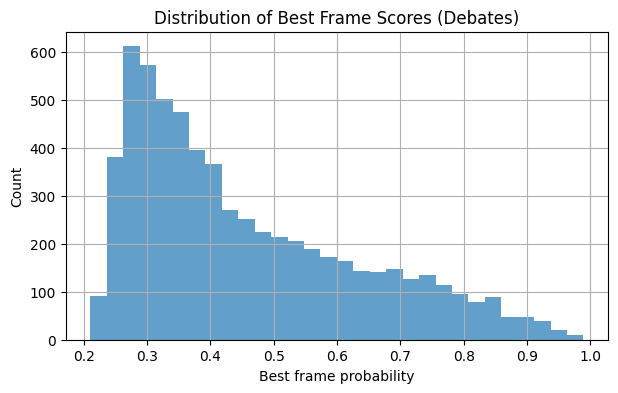

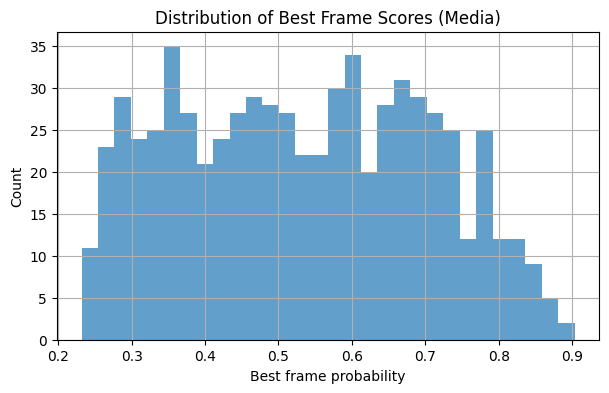

In [14]:
# === DISTRIBUTION OF BEST SCORES ===

def plot_score_distribution(df, dataset_name="dataset"):
    plt.figure(figsize=(7,4))
    df["best_score"].hist(bins=30, alpha=0.7)
    plt.title(f"Distribution of Best Frame Scores ({dataset_name})")
    plt.xlabel("Best frame probability")
    plt.ylabel("Count")
    plt.show()

plot_score_distribution(df_debates_frames, "Debates")
plot_score_distribution(df_media_frames, "Media")

In [15]:
# === SUMMARY STATS FOR BEST SCORES ===

print("[INFO] Debates best_score stats:")
print(df_debates_frames["best_score"].describe(), "\n")

print("[INFO] Media best_score stats:")
print(df_media_frames["best_score"].describe())

[INFO] Debates best_score stats:
count    6316.000000
mean        0.456433
std         0.178329
min         0.210535
25%         0.311038
50%         0.400937
75%         0.572720
max         0.989130
Name: best_score, dtype: float64 

[INFO] Media best_score stats:
count    675.000000
mean       0.532696
std        0.167824
min        0.231804
25%        0.382458
50%        0.527411
75%        0.672328
max        0.903451
Name: best_score, dtype: float64


In [16]:
# === AVERAGE PROBABILITY PER FRAME ===

def avg_score_per_frame(df, dataset_name="dataset"):
    stats = df.groupby("best_frame")["best_score"].agg(["mean", "median", "count"]).sort_values("mean", ascending=False)
    print(f"\n[INFO] Avg frame probabilities ({dataset_name}):")
    print(stats.round(3))

avg_score_per_frame(df_debates_frames, "Debates")
avg_score_per_frame(df_media_frames, "Media")


[INFO] Avg frame probabilities (Debates):
                                 mean  median  count
best_frame                                          
economic consequences           0.579   0.575   2220
security and safety             0.469   0.423   1291
fairness and social justice     0.364   0.327    867
morality and ethics             0.352   0.324   1749
legality and constitutionality  0.329   0.304    189

[INFO] Avg frame probabilities (Media):
                                 mean  median  count
best_frame                                          
economic consequences           0.593   0.604    432
security and safety             0.464   0.435    150
legality and constitutionality  0.398   0.391     13
fairness and social justice     0.363   0.319     35
morality and ethics             0.358   0.301     45


[INFO] Debates margin stats:
count    6316.000000
mean        0.249598
std         0.235207
min         0.000050
25%         0.059008
50%         0.162059
75%         0.392635
max         0.983931
Name: margin, dtype: float64 

[INFO] Media margin stats:
count    675.000000
mean       0.345485
std        0.230508
min        0.000077
25%        0.126847
50%        0.342952
75%        0.542550
max        0.876154
Name: margin, dtype: float64


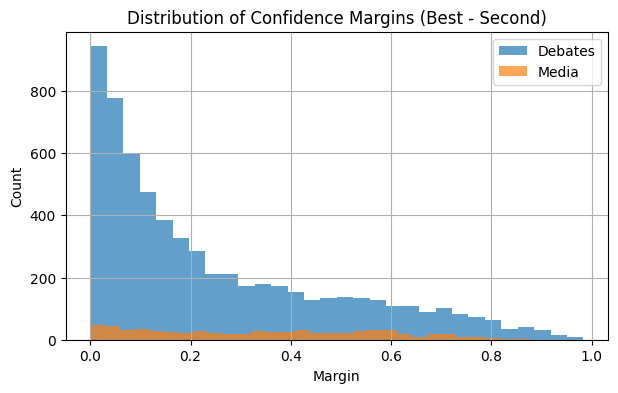

In [17]:
# === CONFIDENCE MARGINS (BEST - SECOND) ===

df_debates_frames["margin"] = df_debates_frames["best_score"] - df_debates_frames["second_score"]
df_media_frames["margin"]   = df_media_frames["best_score"] - df_media_frames["second_score"]

print("[INFO] Debates margin stats:")
print(df_debates_frames["margin"].describe(), "\n")

print("[INFO] Media margin stats:")
print(df_media_frames["margin"].describe())

# plot margin distributions
plt.figure(figsize=(7,4))
df_debates_frames["margin"].hist(bins=30, alpha=0.7, label="Debates")
df_media_frames["margin"].hist(bins=30, alpha=0.7, label="Media")
plt.title("Distribution of Confidence Margins (Best - Second)")
plt.xlabel("Margin")
plt.ylabel("Count")
plt.legend()
plt.show()

### 5.2. Filtering

In [20]:
# === APPLY CONFIDENCE FILTERS ===

THRESH_MAIN = 0.45
THRESH_MARGIN = 0.10

def apply_frame_confidence(row, main=THRESH_MAIN, margin=THRESH_MARGIN):
    if (row["best_score"] < main) or (row["best_score"] - row["second_score"] < margin):
        return "unspecified"
    return row["best_frame"]

# debates
df_debates_frames["frame_final"] = df_debates_frames.apply(apply_frame_confidence, axis=1)

# media
df_media_frames["frame_final"] = df_media_frames.apply(apply_frame_confidence, axis=1)

print("[INFO] Sample debates filtered:")
print(df_debates_frames[["text", "best_frame", "best_score", "second_frame", "second_score", "frame_final"]].head(), "\n")

print("[INFO] Sample media filtered:")
print(df_media_frames[["chunk_text", "best_frame", "best_score", "second_frame", "second_score", "frame_final"]].head())

[INFO] Sample debates filtered:
                                                text  \
0  good evening. the television and radio station...   
1  mr. smith, mr. nixon. in the election of 1860,...   
2  mr. smith, senator kennedy. the things that se...   
3  thank you, mr. nixon. that completes the openi...   
4  senator, the vice president in his campaign ha...   

                       best_frame  best_score                    second_frame  \
0             security and safety    0.234098             morality and ethics   
1           economic consequences    0.313798  legality and constitutionality   
2  legality and constitutionality    0.263287           economic consequences   
3     fairness and social justice    0.272390             security and safety   
4             morality and ethics    0.405186     fairness and social justice   

   second_score  frame_final  
0      0.230609  unspecified  
1      0.212480  unspecified  
2      0.207781  unspecified  
3      0.223716  uns

In [21]:
# === DISTRIBUTION BEFORE VS AFTER ===

def compare_distributions(df, name="dataset"):
    before = df["best_frame"].value_counts(normalize=True) * 100
    after  = df["frame_final"].value_counts(normalize=True) * 100
    comp = pd.concat([before, after], axis=1, keys=["Before %", "After %"]).fillna(0).round(2)
    print(f"\n[INFO] Frame distribution ({name})")
    print(comp)

compare_distributions(df_debates_frames, "Debates")
compare_distributions(df_media_frames, "Media")


[INFO] Frame distribution (Debates)
                                Before %  After %
economic consequences              35.15    25.40
morality and ethics                27.69     3.59
security and safety                20.44     9.07
fairness and social justice        13.73     2.26
legality and constitutionality      2.99     0.35
unspecified                         0.00    59.33

[INFO] Frame distribution (Media)
                                Before %  After %
economic consequences              64.00    51.41
security and safety                22.22     9.93
morality and ethics                 6.67     1.48
fairness and social justice         5.19     0.74
legality and constitutionality      1.93     0.30
unspecified                         0.00    36.15


In [22]:
# === SAVE RESULTS (BEFORE AGGREGATION) ===

OUT_DEBATES = FRAMES_DIR / "debates_frames_simple.csv"
OUT_MEDIA   = FRAMES_DIR / "media_frames_simple.csv"

df_debates_frames.to_csv(OUT_DEBATES, index=False)
df_media_frames.to_csv(OUT_MEDIA, index=False)

print("[DONE] Results saved:")
print("-", OUT_DEBATES)
print("-", OUT_MEDIA)

[DONE] Results saved:
- /content/drive/MyDrive/thesis/data/frames/debates_frames_simple.csv
- /content/drive/MyDrive/thesis/data/frames/media_frames_simple.csv


## 6. Aggregated Debates - Fail

In [14]:
# === AGGREGATE DEBATE UTTERANCES ===
# combine utterances into larger text chunks for more robust framing


FRAMES_DIR = REPO_DIR / "frames"
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

df_debates_frames = pd.read_csv(FRAMES_DIR / "debates_frames_simple.csv")

BATCH_SIZE = 32

AGG_DIR = FRAMES_DIR / "aggregated"
AGG_DIR.mkdir(parents=True, exist_ok=True)

# pick grouping variables depending on available columns
group_cols = ["debate_id", "speaker_normalized", "theme_name"]

# aggregate text
df_debates_agg = (
    df_debates_frames
    .groupby(group_cols)["text"]
    .apply(lambda x: " ".join(x.tolist()))
    .reset_index()
)

print("[INFO] Aggregated debates shape:", df_debates_agg.shape)
print(df_debates_agg.head())

[INFO] Aggregated debates shape: (1254, 4)
                           debate_id speaker_normalized  \
0  1960_1_Presidential_Nixon_Kennedy        Candidate_D   
1  1960_1_Presidential_Nixon_Kennedy        Candidate_D   
2  1960_1_Presidential_Nixon_Kennedy        Candidate_D   
3  1960_1_Presidential_Nixon_Kennedy        Candidate_D   
4  1960_1_Presidential_Nixon_Kennedy        Candidate_D   

                         theme_name  \
0          education_public_schools   
1  foreign_policy_national_security   
2        government_spending_budget   
3        healthcare_social_security   
4              noise_or_unspecified   

                                                text  
0  when uh - the vice president quotes me in janu...  
1  mr. smith, mr. nixon. in the election of 1860,...  
2                no. no. not reducing the interest -  
3  i didn't indicate. i did not advocate reducing...  
4  well, the vice president and i came to the con...  


In [15]:
# === QUICK CHECKS ===

print(f"Shape: {df_debates_agg.shape}")
display(df_debates_agg.head())

Shape: (1254, 4)


,debate_id,speaker_normalized,theme_name,text
0,1960_1_Presidential_Nixon_Kennedy,Candidate_D,education_public_schools,when uh - the vice president quotes me in janu...
1,1960_1_Presidential_Nixon_Kennedy,Candidate_D,foreign_policy_national_security,"mr. smith, mr. nixon. in the election of 1860,..."
2,1960_1_Presidential_Nixon_Kennedy,Candidate_D,government_spending_budget,no. no. not reducing the interest -
3,1960_1_Presidential_Nixon_Kennedy,Candidate_D,healthcare_social_security,i didn't indicate. i did not advocate reducing...
4,1960_1_Presidential_Nixon_Kennedy,Candidate_D,noise_or_unspecified,"well, the vice president and i came to the con..."


In [16]:
# === CLASSIFY AGGREGATED DEBATES ===

agg_texts = df_debates_agg["text"].dropna().tolist()

agg_batches = []
for i in tqdm(range(0, len(agg_texts), BATCH_SIZE), desc="Aggregated Debates"):
    batch_texts = agg_texts[i:i+BATCH_SIZE]
    batch_frames = zeroshot_classify_simple(batch_texts, batch_size=BATCH_SIZE)
    agg_batches.append(batch_frames)

debate_frames_agg = pd.concat(agg_batches, axis=0).reset_index(drop=True)

# merge predictions with metadata
df_debates_agg_frames = pd.concat([df_debates_agg.reset_index(drop=True), debate_frames_agg], axis=1)

print("[INFO] Aggregated debates classified:", df_debates_agg_frames.shape)
print(df_debates_agg_frames[["speaker_normalized", "theme_name", "best_frame", "best_score"]].head())

Aggregated Debates:   0%|          | 0/40 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

Classifying (simple):   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Aggregated debates classified: (1254, 8)
  speaker_normalized                        theme_name             best_frame  \
0        Candidate_D          education_public_schools  economic consequences   
1        Candidate_D  foreign_policy_national_security  economic consequences   
2        Candidate_D        government_spending_budget  economic consequences   
3        Candidate_D        healthcare_social_security  economic consequences   
4        Candidate_D              noise_or_unspecified  economic consequences   

   best_score  
0    0.483127  
1    0.313798  
2    0.804389  
3    0.222262  
4    0.328818  


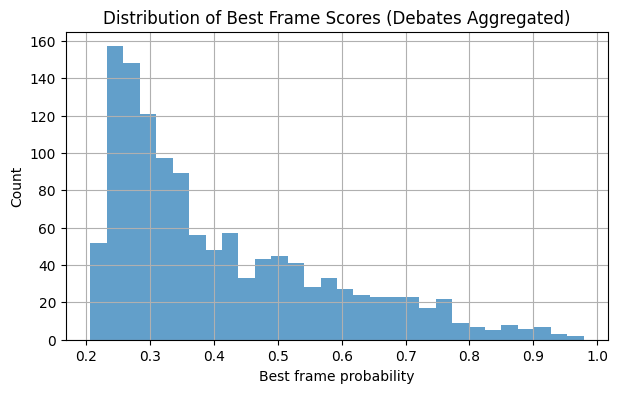

In [18]:
# === DISTRIBUTION OF BEST SCORES ===

def plot_score_distribution(df, dataset_name="dataset"):
    plt.figure(figsize=(7,4))
    df["best_score"].hist(bins=30, alpha=0.7)
    plt.title(f"Distribution of Best Frame Scores ({dataset_name})")
    plt.xlabel("Best frame probability")
    plt.ylabel("Count")
    plt.show()


plot_score_distribution(df_debates_agg_frames, "Debates Aggregated")

In [19]:
# === SUMMARY STATS FOR BEST SCORES ===

print("[INFO] Debates Aggregated best_score stats:")
print(df_debates_agg_frames["best_score"].describe(), "\n")

[INFO] Debates Aggregated best_score stats:
count    1254.000000
mean        0.410192
std         0.169321
min         0.206256
25%         0.275395
50%         0.348479
75%         0.512643
max         0.978859
Name: best_score, dtype: float64 

